# The defocusing nonlinear Schr&ouml;dinger equation

In [23]:
using RiemannHilbert, ApproxFun, SingularIntegralEquations, Plots
include("./RHhelper.jl");

### Solve NLS for small $x$ and $t$

0.28901709868535475 + 3.558893631183668e-17im


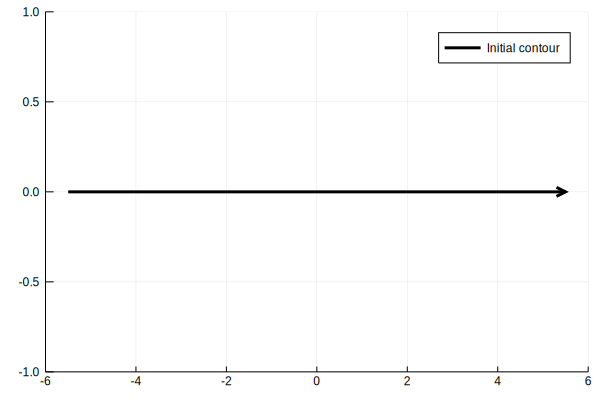

In [24]:
x,t = 0.0,0.0
k = Fun(-5.5 .. 5.5) # truncate at 5.5 where 0.5exp(-5.5^2) is numerically zero
r = 0.5exp(-k^2)
θ = 4t*k^2+2x*k
G = [1-abs2(r)      -conj(r)*exp(-im*θ);
        r*exp(im*θ)      1  ]

Φ = transpose(rhsolve(transpose(G),500))
z = Fun(ℂ)          # the Function z in the complex plane
println(2im*(z*Φ[1,2])(Inf))    # short-hand for taking limits
plot(k.space.domain,xlim = (-6,6),ylim=(-1,1), color =:black, label = "Initial contour", arrows = :arrows, linewidth=3)

### Solve for larger $x$ and $t$

0.0485712062236803 - 0.019957279943570046im

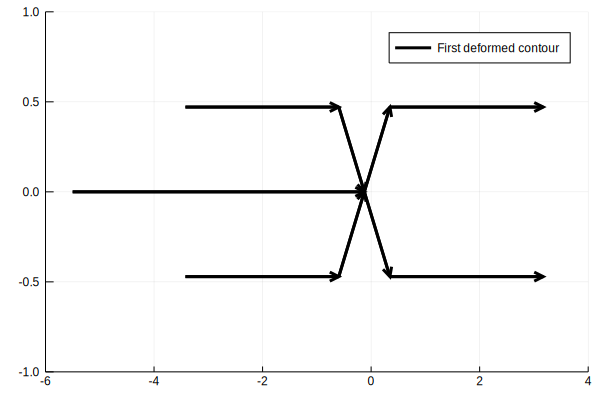

In [25]:
θ = z -> 4t*z^2+2x*z
r = z -> .5*exp(-z^2)
r̄ = z -> conj(r(conj(z)))    

L = z -> [1 0; r(z)/(1-r(z)r̄(z))*exp(im*θ(z)) 1]
D = z -> [1-r(z)r̄(z) 0; 0 1/(1-r(z)r̄(z))]
U = z -> [1 -r̄(z)/(1-r(z)r̄(z))*exp(-im*θ(z)); 0 1]
P = z -> [1 0; r(z)*exp(im*θ(z)) 1]
M = z -> [1 -r̄(z)*exp(-im*θ(z)); 0 1]

x,t = 4.,8.
z₀ = -x/(4t)
rad = .8*sqrt(abs(log(r(0.))))

Γ = (Γ₀(0.,rad) + z₀) ∪ Segment(-5.5,z₀) ∪ (H₀(7)*rad + z₀)
J = [P,M,U,L,D,U,L,P,M] 
G = generateRHP(J,Γ,100)
Φ = transpose(rhsolve(transpose(G),50*length(J)))
z = Fun(ℂ)          
print(2im*(z*Φ[1,2])(Inf))
plot(Γ,xlim = (-6,4),ylim=(-1,1), color =:black, label = "First deformed contour", arrows = :arrows, linewidth=3)

### We can run a contour truncation algorithm to get a better problem

0.04857120575438794 - 0.019957289310737574im

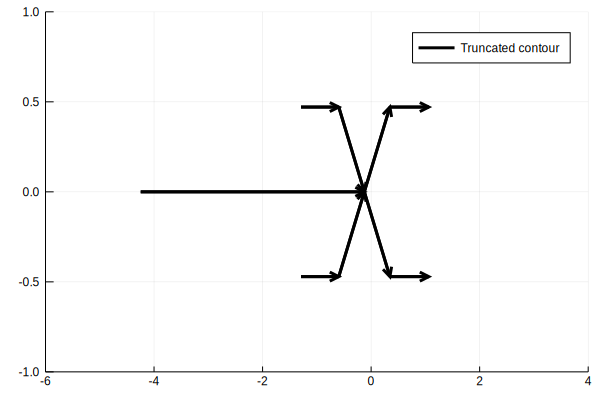

In [26]:
J1,Γ1 = truncateRHP(J,J,Γ,1e-16,30)
G = generateRHP(J1,Γ1,100)
Φ = transpose(rhsolve(transpose(G),100*length(J1)))
z = Fun(ℂ)          
print(2im*(z*Φ[1,2])(Inf))
plot(Γ1,xlim = (-6,4),ylim=(-1,1), color =:black, label = "Truncated contour", arrows = :arrows, linewidth=3)

### But for very large $x$ and $t$ we have to implement everything...

In [27]:
function nls(r,x,t,n,rad) #for t > 0
    θ = z -> 4t*z^2+2x*z
    z₀ = -x/(4t)
    if z₀ < -7.5
        δ = (a,z) -> 1.
    elseif z₀ > 7.5 
        lr = Fun(k -> log(1 - abs2(r(k))), -8..8)
        δ = (a,z) ->  exp(a*cauchy(lr,Complex(z)))
    else
        lr = Fun(k -> log(1 - abs2(r(k))), -8..z₀)
        δ = (a,z) ->  exp(a*cauchy(lr,Complex(z)))
    end
    
    r̄ = z -> conj(r(conj(z)))
    L = z -> [1 0; r(z)/(1-r(z)r̄(z))*exp(im*θ(z)) 1]
    Li = z -> [1 0; -r(z)/(1-r(z)r̄(z))*exp(im*θ(z)) 1]
    D = z -> [1-r(z)r̄(z) 0; 0 1/(1-r(z)r̄(z))]
    U = z -> [1 -r̄(z)/(1-r(z)r̄(z))*exp(-im*θ(z)); 0 1]
    P = z -> [1 0; r(z)*exp(im*θ(z)) 1]
    M = z -> [1 -r̄(z)*exp(-im*θ(z)); 0 1]

    Δ = z -> [δ(1,z) 0; 0 δ(-1,z)]
    Δi = z -> [δ(-1,z) 0; 0 δ(1,z)]
    δLδ = z -> [1 0; r(z)/(1-r(z)r̄(z))*exp(im*θ(z))*δ(-2,z) 1]
    Dδ = z -> [(1-r(z)r̄(z))*δ(-1,z) 0; 0 δ(1,z)/(1-r(z)r̄(z))]
    δUδ = z -> [1 -r̄(z)/(1-r(z)r̄(z))*exp(-im*θ(z))*δ(2,z); 0 1]
    δPδ = z -> [1 0; r(z)*exp(im*θ(z))*δ(-2,z) 1]
    δMδ = z -> [1 -r̄(z)*exp(-im*θ(z))*δ(2,z); 0 1]

    DIδ = z -> (imag(z) >=0 ? Dδ(z) : Δi(z))
    DUδ = z -> D(z)*U(z)*Δi(z)
    LiMδ = z -> Li(z)*M(z)*Δi(z)
    Liδ = z -> Li(z)*Δi(z)
    ρ = .2/(1 + sqrt(t))
    if ρ >= rad
        error("Radii aren't correct")
    end
    Γ = ((Γ₀(ρ,rad) ∪ ρ*S₀) ∪ rad*H₀(4)) + z₀
    J = [δPδ, δMδ, δUδ, δLδ, DUδ, DIδ, Liδ, LiMδ, δUδ, δLδ, δPδ, δMδ];
    J1,Γ1 = truncateRHP(J,J,Γ,1e-16,40)
    if length(components(Γ1)) <= 8
        J2 = [x -> j(z₀ + x/sqrt(t)) for j in J1]
        Γ1 = (Γ1-z₀)*sqrt(t)
        G = generateRHP(J2,Γ1,2*n);
        sc = 1/sqrt(t)
    else
        G = generateRHP(J1,Γ1,2*n);
        sc = 1.
    end
    Φ = transpose(rhsolve(transpose(G),length(components(Γ1))*n));
    z = Fun(ℂ)          
    return 2im*(z*Φ[1,2])(Inf)*sc,Γ1
end

nls (generic function with 1 method)

In [28]:
r = z -> (0.5+0.0im)*exp(-z^2)
rad = .8*abs(sqrt(log(r(0.))))
q = (x,t) -> nls(r,x,t,40,rad);

0.12243123306032332 - 0.058504932338524426im

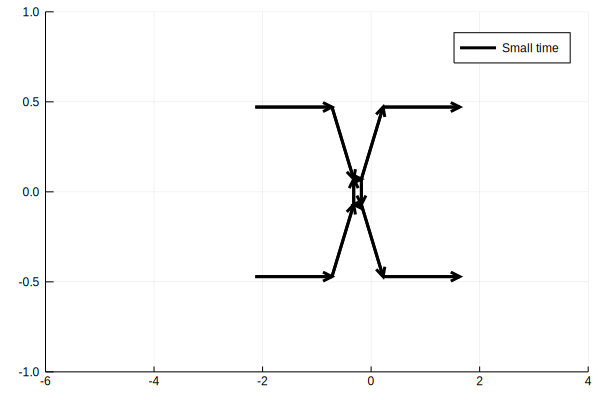

In [29]:
out = q(1.,1.); print(out[1])
plot(out[2],xlim = (-6,4),ylim=(-1,1), color =:black, label = "Small time", arrows = :arrows, linewidth=3)

-0.002426171086327276 + 0.04431412551038007im

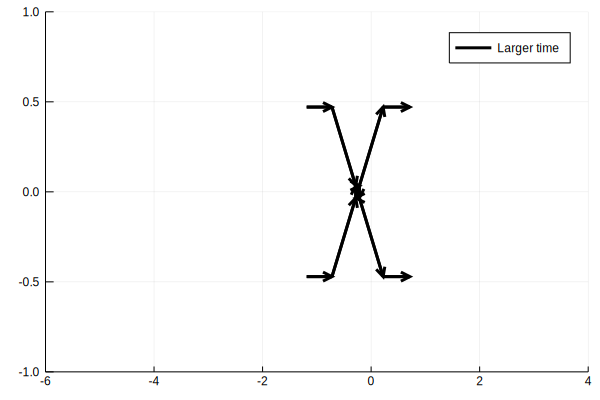

In [30]:
out = q(10.,10.); print(out[1])
plot(out[2],xlim = (-6,4),ylim=(-1,1), color =:black, label = "Larger time", arrows = :arrows, linewidth=3)

0.006161890293791091 - 0.012577725139433985im

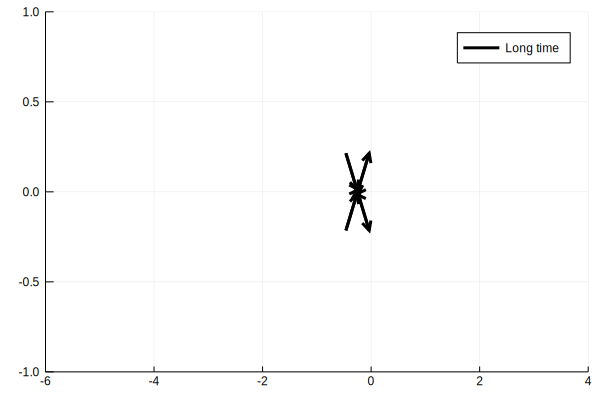

In [31]:
x,t = 100.,100.; out = q(x,t); print(out[1])
plot(out[2]/sqrt(t) - x/(4t),xlim = (-6,4),ylim=(-1,1), color =:black, label = "Long time", arrows = :arrows, linewidth=3)

0.006161890293791091 - 0.012577725139433985im

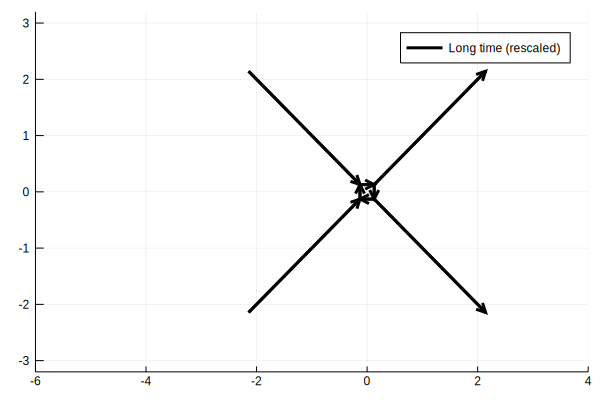

In [32]:
x,t = 100.,100.; out = q(x,t); print(out[1])
plot(out[2],xlim = (-6,4),ylim=(-3.2,3.2), color =:black, label = "Long time (rescaled)", arrows = :arrows, linewidth=3)

-0.0004184841199110484 - 0.0013225400534052im

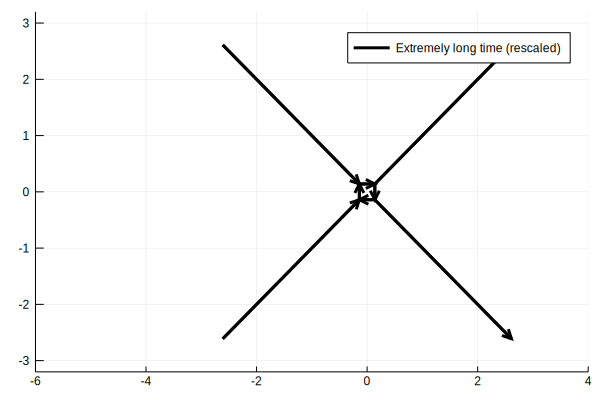

In [33]:
x,t = 10_000.,10_000.; out = q(x,t); print(out[1])
plot(out[2],xlim = (-6,4),ylim=(-3.2,3.2), color =:black, label = "Extremely long time (rescaled)", arrows = :arrows, linewidth=3)